In [1]:
import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP, MixedSingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
fun = Ackley(dim=11, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds

batch_size = 8
n_init = 10
max_cholesky_size = float("inf")  # Always use Cholesky


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

In [34]:
dim, lb, ub

(11,
 tensor([-5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
        dtype=torch.float64),
 tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
        dtype=torch.float64))

In [35]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8 # 0.4
    length_min: float = 0.5**7
    length_max: float = 1.6 # 2.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10 # 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [36]:
state = TurboState(dim=dim, batch_size=batch_size)
print(state)

TurboState(dim=11, batch_size=8, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=2, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


In [37]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init


In [38]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(10000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, Y.max())
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

### Expected Improveemnt (EI)

In [39]:

# n_seeds = 10
# for i in range(n_seeds):
#     print(f'iteration {i+1}')
#     torch.manual_seed(i)
#     X_turbo = get_initial_points(dim, n_init)

#     Y_turbo = torch.tensor(
#         [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
#     ).unsqueeze(-1)

#     state = TurboState(dim, batch_size=batch_size)

#     NUM_RESTARTS = 10 if not SMOKE_TEST else 2
#     RAW_SAMPLES = 512 if not SMOKE_TEST else 4
#     N_CANDIDATES = min(6000, max(2000, 200 * dim)) if not SMOKE_TEST else 4


#     best_scores = []

#     while not state.restart_triggered:  # Run until TuRBO converges
#         # Fit a GP model
#         train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
#         likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-0))
#         covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
#             MaternKernel(
#                 nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
#             )
#         )
#         model = SingleTaskGP(
#             X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood
#         )
#         mll = ExactMarginalLogLikelihood(model.likelihood, model)

#         # Do the fitting and acquisition function optimization inside the Cholesky context
#         with gpytorch.settings.max_cholesky_size(max_cholesky_size):
#             # Fit the model
#             fit_gpytorch_mll(mll)

#             # Create a batch
#             X_next = generate_batch(
#                 state=state,
#                 model=model,
#                 X=X_turbo,
#                 Y=train_Y,
#                 batch_size=batch_size,
#                 n_candidates=N_CANDIDATES,
#                 num_restarts=NUM_RESTARTS,
#                 raw_samples=RAW_SAMPLES,
#                 acqf="ei",
#             )

#         Y_next = torch.tensor(
#             [eval_objective(x) for x in X_next], dtype=dtype, device=device
#         ).unsqueeze(-1)

#         # Update state
#         state = update_state(state=state, Y_next=Y_next)

#         # Append data
#         X_turbo = torch.cat((X_turbo, X_next), dim=0)
#         Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

#         # Print current status
#         best_scores.append(state.best_value)
#         # print(
#         #     f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
#         # )

#     best_scores = np.array(best_scores)
#     plt.plot(range(best_scores.shape[0]), best_scores)
#     plt.scatter(best_scores.shape[0], best_scores[-1], color='black')
# plt.show()


### Thompson sampling

round 1
Y dataset shape:  torch.Size([250, 1])
round 2
Y dataset shape:  torch.Size([250, 1])
round 3
Y dataset shape:  torch.Size([250, 1])
round 4
Y dataset shape:  torch.Size([250, 1])
round 5
Y dataset shape:  torch.Size([250, 1])
round 6
Y dataset shape:  torch.Size([250, 1])
round 7
Y dataset shape:  torch.Size([250, 1])
round 8
Y dataset shape:  torch.Size([250, 1])
round 9
Y dataset shape:  torch.Size([250, 1])
round 10
Y dataset shape:  torch.Size([250, 1])


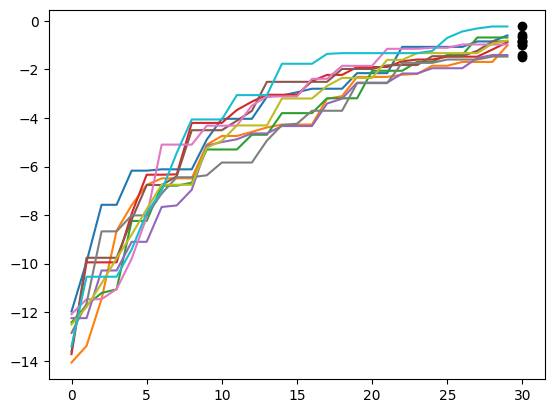

In [40]:
import time
current_time= time.time()
n_seeds = 10
all_scores = []
for i in range(n_seeds):
    print(f'round {i+1}')
    torch.manual_seed(i)
    current_time = time.time()
    X_turbo = get_initial_points(dim, n_init)

    Y_turbo = torch.tensor(
        [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
    ).unsqueeze(-1)

    state = TurboState(dim, batch_size=batch_size)

    NUM_RESTARTS = 20 if not SMOKE_TEST else 2
    RAW_SAMPLES = 512 if not SMOKE_TEST else 4
    N_CANDIDATES = min(6000, max(4000, 200 * dim)) if not SMOKE_TEST else 4

    best_scores = []

    while Y_turbo.shape[0] < 250:# not state.restart_triggered:  # Run until TuRBO converges
        # Fit a GP model
        start_time = time.time()
        train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-0))
        covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
            MaternKernel(
                nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
            )
        )
        model = SingleTaskGP(
            X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood
        )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        # Do the fitting and acquisition function optimization inside the Cholesky context
        with gpytorch.settings.max_cholesky_size(max_cholesky_size):
            # Fit the model
            fit_gpytorch_mll(mll)

            # Create a batch
            X_next = generate_batch(
                state=state,
                model=model,
                X=X_turbo,
                Y=train_Y,
                batch_size=batch_size,
                n_candidates=N_CANDIDATES,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                acqf="ts",
            )
        # print(f'{time.time() - start_time}')

        Y_next = torch.tensor(
            [eval_objective(x) for x in X_next], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Update state
        state = update_state(state=state, Y_next=Y_next)

        # Append data
        X_turbo = torch.cat((X_turbo, X_next), dim=0)
        Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

        # Print current status
        best_scores.append(state.best_value)
        # print(
        #     f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
        # )
    best_scores = np.array(best_scores)    
    all_scores.append(best_scores)
    plt.plot(range(best_scores.shape[0]), best_scores)
    plt.scatter(best_scores.shape[0], best_scores[-1], color='black')
    print('Y dataset shape: ', Y_turbo.shape)
plt.show()

In [41]:
# all_scores1 = np.array(all_scores)
# print(all_scores1.shape)
# all_scores_mean1 = np.mean(all_scores1, axis=0)
# all_scores2 = np.array(all_scores)
# print(all_scores2.shape)
# all_scores_mean2 = np.mean(all_scores2, axis=0)

# all_scores4 = np.array(all_scores)
# print(all_scores4.shape)
# all_scores_mean4 = np.mean(all_scores4, axis=0)

all_scores8 = np.array(all_scores)
print(all_scores8.shape)
all_scores_mean8 = np.mean(all_scores8, axis=0)


(10, 30)


In [1]:
plt.plot(np.arange(250-n_init), all_scores_mean1, label='1 parallel evaluation')
plt.plot(2*np.arange(all_scores_mean2.shape[0]), all_scores_mean2, label='2 parallel evaluations')
plt.plot(4*np.arange(all_scores_mean4.shape[0]), all_scores_mean4, label='4 parallel evaluations')
plt.plot(8*np.arange(all_scores_mean8.shape[0]), all_scores_mean8, label='8 parallel evaluations')

plt.title('The effect of parallization on sample efficiency')
plt.axhline(y=0., color='gray', linestyle=':')
plt.ylabel('Score')
plt.xlabel('Evaluations')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## GP-Expected Improvement
As a baseline, we compare TuRBO to qEI

In [ ]:
60 * 9, 80*9

In [ ]:
len(Y_turbo)

In [ ]:
# for i in range(10):    
#     torch.manual_seed(i)

#     X_ei = get_initial_points(dim, n_init)
#     Y_ei = torch.tensor(
#         [eval_objective(x) for x in X_ei], dtype=dtype, device=device
#     ).unsqueeze(-1)
#     best_scores = []

#     NUM_RESTARTS = 10 if not SMOKE_TEST else 2
#     RAW_SAMPLES = 512 if not SMOKE_TEST else 4
#     N_CANDIDATES = min(6000, max(2000, 200 * dim)) if not SMOKE_TEST else 4

#     while len(Y_ei) < 130:
#         train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
#         likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
#         covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
#             MaternKernel(
#                 nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
#             )
#         )
#         model = SingleTaskGP(X_ei, train_Y, covar_module=covar_module, likelihood=likelihood)
#         mll = ExactMarginalLogLikelihood(model.likelihood, model)
#         fit_gpytorch_mll(mll)

#         # Create a batch
#         ei = qExpectedImprovement(model, train_Y.max())
#         candidate, acq_value = optimize_acqf(
#             ei,
#             bounds=torch.stack(
#                 [
#                     torch.zeros(dim, dtype=dtype, device=device),
#                     torch.ones(dim, dtype=dtype, device=device),
#                 ]
#             ),
#             q=batch_size,
#             num_restarts=NUM_RESTARTS,
#             raw_samples=RAW_SAMPLES,
#         )
#         Y_next = torch.tensor(
#             [eval_objective(x) for x in candidate], dtype=dtype, device=device
#         ).unsqueeze(-1)

#         # Append data
#         X_ei = torch.cat((X_ei, candidate), axis=0)
#         Y_ei = torch.cat((Y_ei, Y_next), axis=0)

#         # Print current status
#         best_scores.append(Y_ei.max().item())
#         # print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

#     best_scores = np.array(best_scores)
#     plt.plot(range(best_scores.shape[0]), best_scores)
#     plt.scatter(best_scores.shape[0], best_scores[-1], color='black')

# plt.show()